
# Vision Transformer (ViT) with CIFAR-10 Dataset

### What is Vision Transformer (ViT)?

The Vision Transformer (ViT) is a state-of-the-art model that adapts the Transformer architecture, originally designed for NLP tasks, to image data. 
Instead of processing images as pixels, ViT splits them into smaller patches, embeds these patches, and then processes them using Transformer layers.

Key Steps in ViT:
1. **Patch Extraction**: The image is divided into non-overlapping patches.
2. **Linear Projection**: Each patch is flattened and passed through a linear layer to create patch embeddings.
3. **Positional Encoding**: Positional information is added to patch embeddings to retain spatial context.
4. **Transformer Encoder**: A standard Transformer encoder processes the patch embeddings, attending to their relationships.
5. **Classification**: A special class token is added, and its representation is used for classification tasks.

This notebook demonstrates the following:
- Preprocessing of the CIFAR-10 dataset.
- Visualization of sample images.
- Insights into how data is prepared for input to a ViT model.

---

In [94]:
!pip install einops

In [95]:
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor
import math
import torch.nn.functional as F
import torch
import random
import numpy as np

In [96]:
def set_seed(seed):
    """
    Set a fixed seed for reproducibility across multiple libraries and hardware.

    Args:
        seed: An integer value to be used as the seed for random number generation.
    """
    random.seed(seed)  # Set the seed for Python's built-in random module
    np.random.seed(seed)  # Set the seed for NumPy's random number generator
    torch.manual_seed(seed)  # Set the seed for PyTorch's CPU random number generator
    torch.cuda.manual_seed(seed)  # Set the seed for PyTorch's single GPU random number generator
    torch.cuda.manual_seed_all(seed)  # Set the seed for all GPUs in the system (if available)
    
    # Ensure deterministic behavior for CUDNN backend
    torch.backends.cudnn.deterministic = True  # Force CUDNN to use deterministic algorithms
    torch.backends.cudnn.benchmark = False  # Disable CUDNN auto-tuner for deterministic results (may reduce performance)

# Set the seed for reproducibility
seed = 42
set_seed(seed)

In [97]:
def denormalize(tensor, mean, std):
    """
    Perform reverse normalization on a tensor.
    
    Args:
        tensor: The normalized tensor (C x H x W), where C is the number of channels (e.g., R, G, B),
                H is the height, and W is the width.
        mean: Mean values for each channel (R, G, B).
        std: Standard deviation values for each channel (R, G, B).

    Returns:
        A tensor converted back to its original value range.
    """
    mean = torch.tensor(mean).view(3, 1, 1)  # Reshape the mean to (C, 1, 1) for broadcasting
    std = torch.tensor(std).view(3, 1, 1)    # Reshape the standard deviation to (C, 1, 1) for broadcasting
    return tensor * std + mean  # Reverse the normalization by scaling and shifting

Files already downloaded and verified

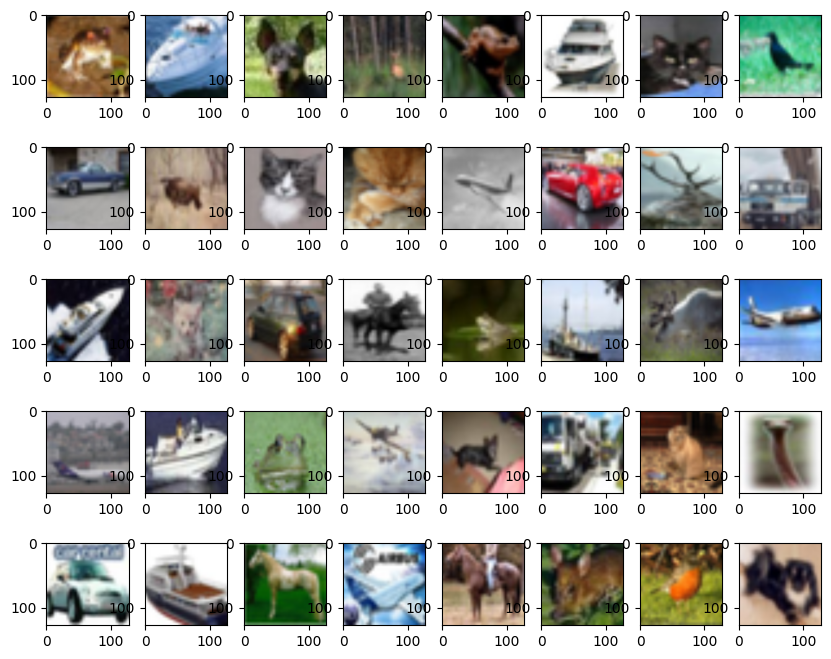

In [98]:
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, ToPILImage
from torch.utils.data import DataLoader

# Define transforms and dataset
class SimpleCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)
        return image

# Helper function to display images
def show_images(images, num_samples=40, cols=8, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(10, 10))
    idx = max(1, int(len(images) / num_samples))
    for i, (img, _) in enumerate(images):
        if i % idx == 0:
            plt.subplot(int(num_samples / cols) + 1, cols, i // idx + 1)
            # Ters normalizasyon
            denormalized_img = denormalize(img, mean, std)
            plt.imshow(ToPILImage()(denormalized_img))
            if i >= num_samples * idx:
                break
    plt.show()

to_tensor = [Resize((128, 128)), ToTensor(),Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]

dataset = CIFAR10(
    root=".", 
    download=True, 
    transform=SimpleCompose(to_tensor
))


# Show a few samples from CIFAR-10
show_images(dataset)

In [99]:
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, ColorJitter, Resize, ToTensor, Normalize

# Define transformations for training data
train_transform = Compose([
    RandomHorizontalFlip(p=0.5),  # Apply horizontal flip with a 50% probability
    RandomRotation(degrees=15),  # Apply random rotation within ±15 degrees
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly adjust brightness, contrast, and saturation
    Resize((128, 128)),  # Resize all images to a fixed size of 128x128 pixels
    ToTensor(),  # Convert image to PyTorch tensor format (C x H x W)
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize the image with specified mean and standard deviation
])

# Define transformations for test/validation data
test_transform = Compose([
    Resize((128, 128)),  # Resize all images to a fixed size of 128x128 pixels
    ToTensor(),  # Convert im

In [100]:
train_dataset=CIFAR10(
    root=".",train=True, 
    download=True, 
    transform=train_transform)
test_dataset=CIFAR10(
    root=".", train=False, 
    download=True, 
    transform=test_transform)
print(len(train_dataset),len(test_dataset))

Files already downloaded and verifiedFiles already downloaded and verified50000 10000

In [101]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 8, emb_size = 128):
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self,x):
        x=self.projection(x)
        return x
def scaled_dot_product(q, k, v, mask=None):
    # q: 30 x 8 x 200 x 64, k: 30 x 8 x 200 x 64, v: 30 x 8 x 200 x 64, mask 200 x 200
    d_k = q.size()[-1] 
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k) # 30 x 8 x 200 x 200
    #print(f"scaled.size() : {scaled.size()}")
    if mask is not None:
        #print(f"-- ADDING MASK of shape {mask.size()} --") 
        scaled += mask # 30 x 8 x 200 x 200
    attention = F.softmax(scaled, dim=-1) # 30 x 8 x 200 x 200
    values = torch.matmul(attention, v) # 30 x 8 x 200 x 64
    return values, attention

class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, max_sequence_length, d_model = x.size()
        #print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        #print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, max_sequence_length, self.num_heads, 3 * self.head_dim)
        #print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        #print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        #print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        #print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, max_sequence_length, self.num_heads * self.head_dim)
        #print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        #print(f"out.size(): {out.size()}")
        return out
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape)) # 512
        self.beta =  nn.Parameter(torch.zeros(parameters_shape)) # 512

    def forward(self, inputs):
        # inputs : 30 x 200 x 512
        dims = [-(i + 1) for i in range(len(self.parameters_shape))] # [-1]
        #print(f"dims: {dims}")
        mean = inputs.mean(dim=dims, keepdim=True) #30 x 200 x 1
        #print(f"Mean ({mean.size()})")
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True) # 30 x 200 x 512
        std = (var + self.eps).sqrt() # 30 x 200 x 512
        #print(f"Standard Deviation  ({std.size()})")
        y = (inputs - mean) / std # 30 x 200 x 512
        #print(f"y: {y.size()}")
        out = self.gamma * y  + self.beta  # 30 x 200 x 512
        #print(f"out: {out.size()}")
        return out
    
class FeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(p=drop_prob)
        self.linear2 = nn.Linear(hidden, d_model)

    def forward(self, x):
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x
class Attention(nn.Module):
    def __init__(self, dim, n_heads): #dropout
        super().__init__()
        self.n_heads = n_heads
        self.att =MultiHeadAttention(d_model=dim,num_heads=n_heads,)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = scaled_dot_product(q,k,v)
        return attn_output
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = LayerNormalization(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x
residual_att = ResidualAdd(Attention(dim=128, n_heads=4))

In [116]:
class PatchEmbedding(nn.Module):
    """
    This class extracts patches from the input image and projects them into a lower-dimensional embedding space.
    """
    def __init__(self, in_channels=3, patch_size=8, emb_size=128):
        super().__init__()
        self.projection = nn.Sequential(
            # Rearrange the input image into patches
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            # Linear transformation to project patches to embedding space
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x):
        x = self.projection(x)  # Apply the patch embedding
        return x


def scaled_dot_product(q, k, v, mask=None):
    """
    Computes scaled dot-product attention.
    
    Args:
        q: Query matrix of shape (batch_size, num_heads, seq_len, head_dim)
        k: Key matrix of shape (batch_size, num_heads, seq_len, head_dim)
        v: Value matrix of shape (batch_size, num_heads, seq_len, head_dim)
        mask: Optional mask to prevent attending to certain positions

    Returns:
        values: Attention-weighted values of shape (batch_size, num_heads, seq_len, head_dim)
        attention: Attention weights of shape (batch_size, num_heads, seq_len, seq_len)
    """
    d_k = q.size()[-1]  # Get the dimensionality of the key
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)  # Scale dot product
    if mask is not None:
        scaled += mask  # Add the mask if provided
    attention = F.softmax(scaled, dim=-1)  # Apply softmax to get attention weights
    values = torch.matmul(attention, v)  # Compute attention-weighted values
    return values, attention


class MultiHeadAttention(nn.Module):
    """
    Implements multi-head attention mechanism with linear projections for query, key, and value.
    """
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model  # Dimensionality of input features
        self.num_heads = num_heads  # Number of attention heads
        self.head_dim = d_model // num_heads  # Dimensionality of each head
        self.qkv_layer = nn.Linear(d_model, 3 * d_model)  # Combine query, key, and value projections
        self.linear_layer = nn.Linear(d_model, d_model)  # Final linear layer

    def forward(self, x, mask=None):
        batch_size, max_sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x)  # Compute query, key, value projections
        qkv = qkv.reshape(batch_size, max_sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)  # Rearrange to (batch_size, num_heads, seq_len, 3 * head_dim)
        q, k, v = qkv.chunk(3, dim=-1)  # Split into query, key, and value
        values, attention = scaled_dot_product(q, k, v, mask)  # Compute scaled dot-product attention
        values = values.reshape(batch_size, max_sequence_length, self.num_heads * self.head_dim)
        out = self.linear_layer(values)  # Project back to original dimension
        return out


class LayerNormalization(nn.Module):
    """
    Implements layer normalization, normalizing the input across features.
    """
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape = parameters_shape
        self.eps = eps  # Epsilon for numerical stability
        self.gamma = nn.Parameter(torch.ones(parameters_shape))  # Scale parameter
        self.beta = nn.Parameter(torch.zeros(parameters_shape))  # Shift parameter

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]  # Normalize across features
        mean = inputs.mean(dim=dims, keepdim=True)  # Compute mean
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)  # Compute variance
        std = (var + self.eps).sqrt()  # Compute standard deviation
        y = (inputs - mean) / std  # Normalize input
        out = self.gamma * y + self.beta  # Scale and shift
        return out


class FeedForward(nn.Module):
    """
    Implements a feed-forward network with GELU activation and dropout.
    """
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, hidden)  # First linear layer
        self.gelu = nn.GELU()  # GELU activation
        self.dropout = nn.Dropout(p=drop_prob)  # Dropout for regularization
        self.linear2 = nn.Linear(hidden, d_model)  # Second linear layer

    def forward(self, x):
        x = self.linear1(x)  # Apply first linear layer
        x = self.gelu(x)  # Apply GELU activation
        x = self.dropout(x)  # Apply dropout
        x = self.linear2(x)  # Apply second linear layer
        x = self.dropout(x)  # Apply dropout again
        return x


class Attention(nn.Module):
    """
    A simplified attention mechanism using linear projections for query, key, and value.
    """
    def __init__(self, dim, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.att = MultiHeadAttention(d_model=dim, num_heads=n_heads)
        self.q = torch.nn.Linear(dim, dim)  # Linear projection for query
        self.k = torch.nn.Linear(dim, dim)  # Linear projection for key
        self.v = torch.nn.Linear(dim, dim)  # Linear projection for value

    def forward(self, x):
        q = self.q(x)  # Compute query
        k = self.k(x)  # Compute key
        v = self.v(x)  # Compute value
        attn_output, attn_output_weights = scaled_dot_product(q, k, v)  # Compute attention
        return attn_output


class PreNorm(nn.Module):
    """
    A wrapper that applies layer normalization before a given function.
    """
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = LayerNormalization(dim)  # Layer normalization
        self.fn = fn  # Function to apply

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)  # Normalize input and apply function


class ResidualAdd(nn.Module):
    """
    Implements a residual connection by adding the input to the output of a function.
    """
    def __init__(self, fn):
        super().__init__()
        self.fn = fn  # Function to apply

    def forward(self, x, **kwargs):
        res = x  # Store the input as the residual
        x = self.fn(x, **kwargs)  # Apply the function
        x += res  # Add the residual to the output
        return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.7490196].

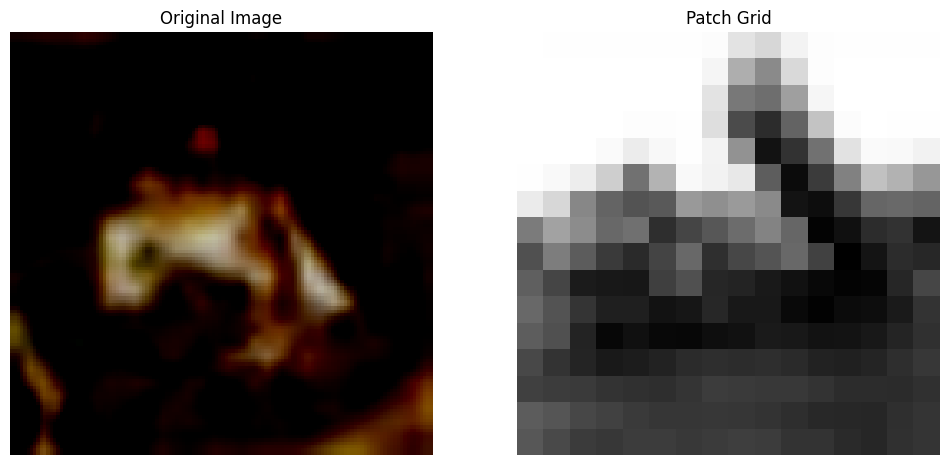

In [103]:
def visualize_patches_with_original(image, patches, img_size=128, patch_size=8):
    """
    Patch embedding'lerini orijinal görüntüyle birlikte görselleştirir.
    
    Args:
        image (torch.Tensor): Orijinal görüntü tensörü [C, H, W].
        patches (torch.Tensor): Patch tensörü [B, N, D].
        img_size (int): Orijinal görüntü boyutu (ör. 128).
        patch_size (int): Patch boyutu (ör. 8).
    """
    grid_size = img_size // patch_size  # Grid boyutu (ör. 16x16)
    b, n, d = patches.shape

    assert grid_size ** 2 == n, "Patch sayısı, grid boyutuyla uyuşmuyor!"
    
    # Orijinal görüntü
    image = image.permute(1, 2, 0).detach().numpy()  # [H, W, C]
    
    # Patch'leri görselleştirme için 2D grid'e dönüştür
    patch_grid = patches[0].reshape(grid_size, grid_size, d)  # [16, 16, D]
    patch_grid = patch_grid.mean(dim=-1)  # Her patch'in ortalamasını al (D -> 1)

    plt.figure(figsize=(12, 6))
    
    # Orijinal görüntü
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original Image")
    
    # Patch grid
    plt.subplot(1, 2, 2)
    plt.imshow(patch_grid.detach().numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Patch Grid")
    
    plt.show()

# Orijinal görüntüyü al
original_image = train_dataset[0][0]
visualize_patches_with_original(original_image, embedding, img_size=128, patch_size=8)

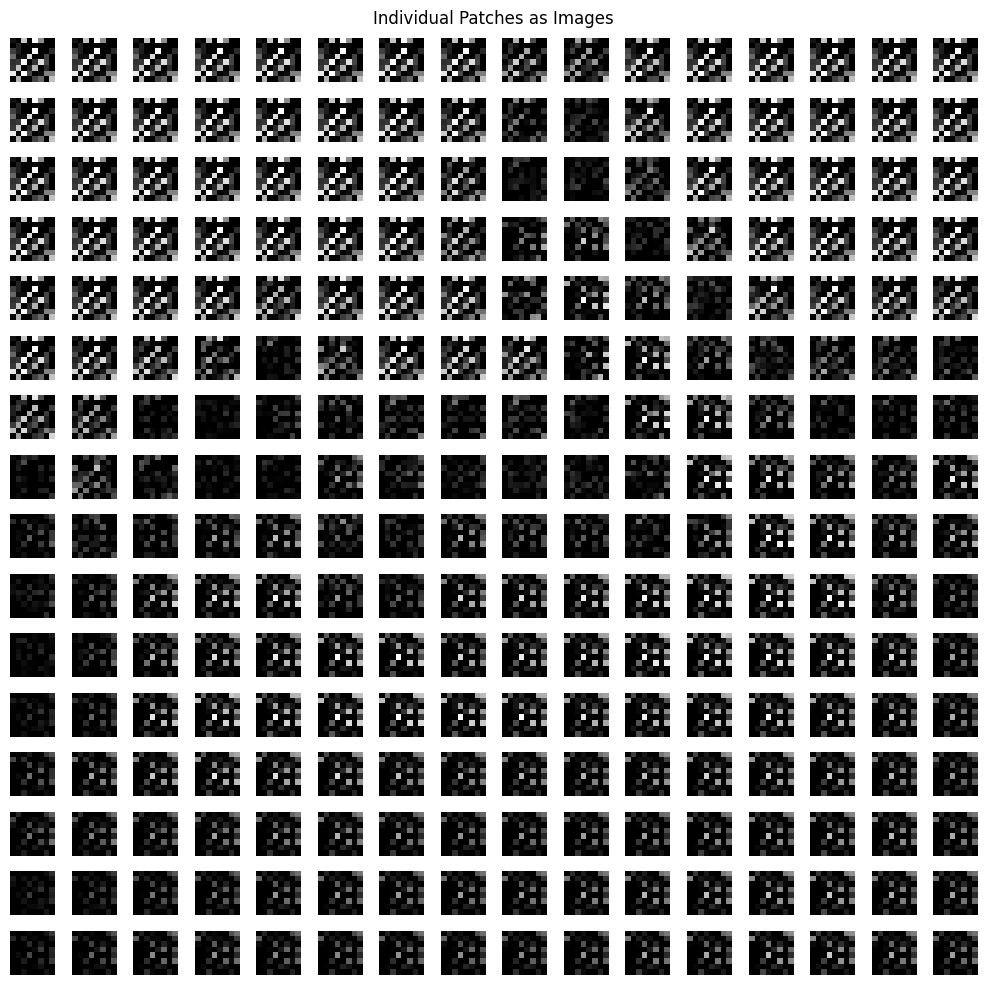

In [105]:
def visualize_individual_patches_as_images(patches, img_size=128, patch_size=8):
    """
    Patch embedding'lerini ayrı ayrı 2D görüntü olarak görselleştirir.

    Args:
        patches (torch.Tensor): Patch tensörü [B, N, D].
        img_size (int): Orijinal görüntü boyutu (ör. 128).
        patch_size (int): Patch boyutu (ör. 8x8).
    """
    b, n, d = patches.shape
    grid_size = int(img_size / patch_size)  # Grid boyutu (ör. 16x16)

    assert grid_size ** 2 == n, "Patch sayısı, grid boyutuyla uyuşmuyor!"
    assert d >= patch_size ** 2, "Embedding boyutu, patch boyutuyla uyuşmuyor!"

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    fig.suptitle("Individual Patches as Images")

    for i in range(grid_size):
        for j in range(grid_size):
            patch = patches[0, i * grid_size + j, :patch_size**2]  # İlk 64 değeri al
            patch = patch.reshape(patch_size, patch_size).detach().numpy()  # 2D tensöre dönüştür
            axes[i, j].imshow(patch, cmap="gray", vmin=0, vmax=1)
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

# Fonksiyonu çağır
visualize_individual_patches_as_images(embedding, img_size=128, patch_size=8)

In [117]:
from einops import repeat

class ViT(nn.Module):
    """
    Vision Transformer (ViT) implementation for image classification tasks.
    """
    def __init__(self, ch=3, img_size=128, patch_size=8, emb_dim=128,
                 n_layers=16, out_dim=10, dropout=0.1, heads=8):
        """
        Args:
            ch: Number of input channels (e.g., 3 for RGB images).
            img_size: Height/width of the input images (assumed to be square).
            patch_size: Size of each image patch.
            emb_dim: Dimensionality of patch embeddings.
            n_layers: Number of Transformer layers in the encoder.
            out_dim: Number of output classes for classification.
            dropout: Dropout probability for feed-forward layers.
            heads: Number of attention heads in the multi-head attention mechanism.
        """
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)  # Embed patches into vectors

        # Learnable parameters
        num_patches = (img_size // patch_size) ** 2  # Calculate total number of patches
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))  # Positional embedding for patches and class token
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))  # Learnable classification token

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                # Residual block with layer normalization and attention
                ResidualAdd(PreNorm([emb_dim], Attention(emb_dim, n_heads=heads))),
                # Residual block with layer normalization and feed-forward network
                ResidualAdd(PreNorm([emb_dim], FeedForward(emb_dim, emb_dim, drop_prob=dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(
            nn.LayerNorm(emb_dim),  # Normalize embedding
            nn.Linear(emb_dim, out_dim)  # Map to class scores
        )

    def forward(self, img):
        """
        Forward pass through the Vision Transformer.

        Args:
            img: Input image tensor of shape (batch_size, channels, height, width).

        Returns:
            Class scores of shape (batch_size, out_dim).
        """
        # Get patch embedding vectors
        x = self.patch_embedding(img)  # Shape: (batch_size, num_patches, emb_dim)
        b, n, _ = x.shape

        # Add classification token to the inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)  # Repeat class token for the batch
        x = torch.cat([cls_tokens, x], dim=1)  # Concatenate class token with patch embeddings
        x += self.pos_embedding[:, :(n + 1)]  # Add positional embedding

        # Pass through Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])  # Use only the class token for classification


# Instantiate the model
model = ViT()
print(model)  

# Test the model with a dummy input
model(torch.ones((1, 3, 128, 128)))  # Input: Batch size = 1, Channels = 3, Image size = 128x128

ViT(  (patch_embedding): PatchEmbedding(    (projection): Sequential(      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)      (1): Linear(in_features=192, out_features=128, bias=True)    )  )  (layers): ModuleList(    (0-15): 16 x Sequential(      (0): ResidualAdd(        (fn): PreNorm(          (norm): LayerNormalization()          (fn): Attention(            (att): MultiHeadAttention(              (qkv_layer): Linear(in_features=128, out_features=384, bias=True)              (linear_layer): Linear(in_features=128, out_features=128, bias=True)            )            (q): Linear(in_features=128, out_features=128, bias=True)            (k): Linear(in_features=128, out_features=128, bias=True)            (v): Linear(in_features=128, out_features=128, bias=True)          )        )      )      (1): ResidualAdd(        (fn): PreNorm(          (norm): LayerNormalization()          (fn): FeedForward(            (linear1): Linear(in_features=128, out_features=128, bias

tensor([[-0.3059,  0.2649,  0.2940,  0.1484, -0.4723,  0.4152,  0.2418,  0.4389,          0.0318, -0.3036]], grad_fn=<AddmmBackward0>)

In [107]:
from torch.utils.data import DataLoader,Subset
from torch.utils.data import random_split
g = torch.Generator()
g.manual_seed(seed)

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=g)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 50000Test set size: 10000

In [108]:
import torch.optim as optim
import numpy as np
import os

device = "cuda"
model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # Added weight decay
criterion = nn.CrossEntropyLoss()

# Scheduler: Reduce LR if val loss doesn't improve for 5 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early Stopping
patience = 8  # Maximum patience for early stopping
best_loss = float('inf')  # Initially set the best loss to infinity
trigger_times = 0  # Count consecutive epochs without improvement

# Checkpoint directory
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(200):  # Maximum epoch count
    # Training Mode
    model.train()
    epoch_train_losses = []
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())

    train_loss = np.mean(epoch_train_losses)
    print(f">>> Epoch {epoch} train loss: {train_loss:.4f}")

    # Validation Mode
    model.eval()
    epoch_test_losses = []
    with torch.no_grad():
        for step, (inputs, labels) in enumerate(test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_test_losses.append(loss.item())

    test_loss = np.mean(epoch_test_losses)
    print(f">>> Epoch {epoch} test loss: {test_loss:.4f}")

    # Checkpointing every 10 epochs
    if epoch % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

    # Save the model if validation loss improves
    if test_loss < best_loss:
        best_loss = test_loss
        trigger_times = 0  # Reset patience counter
        print(f"Test loss improved to {best_loss:.4f}, saving model...")
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pth"))
    else:
        trigger_times += 1  # Increment patience counter
        print(f"No improvement in test loss. Trigger times: {trigger_times}")

        # Early Stopping
        if trigger_times >= patience:
            print("Early stopping triggered. Training stopped.")
            break


    # Step the scheduler
    previous_lr = optimizer.param_groups[0]['lr']  # Scheduler öncesi learning rate
    scheduler.step(test_loss)
    current_lr = optimizer.param_groups[0]['lr']  # Scheduler sonrası learning rate
    
    if current_lr < previous_lr:
        print(f"Scheduler updated: Learning rate reduced from {previous_lr:.6f} to {current_lr:.6f}")
    else:
        print(f"Scheduler checked: Learning rate remains {current_lr:.6f}")
    


>>> Epoch 0 train loss: 1.9094>>> Epoch 0 test loss: 1.7969Checkpoint saved: ./checkpoints/checkpoint_epoch_0.pthTest loss improved to 1.7969, saving model...Scheduler checked: Learning rate remains 0.001000>>> Epoch 1 train loss: 1.7957>>> Epoch 1 test loss: 1.7134Test loss improved to 1.7134, saving model...Scheduler checked: Learning rate remains 0.001000>>> Epoch 2 train loss: 1.7646>>> Epoch 2 test loss: 1.6719Test loss improved to 1.6719, saving model...Scheduler checked: Learning rate remains 0.001000>>> Epoch 3 train loss: 1.6831>>> Epoch 3 test loss: 1.7354No improvement in test loss. Trigger times: 1Scheduler checked: Learning rate remains 0.001000>>> Epoch 4 train loss: 1.6544>>> Epoch 4 test loss: 1.5884Test loss improved to 1.5884, saving model...Scheduler checked: Learning rate remains 0.001000>>> Epoch 5 train loss: 1.6164>>> Epoch 5 test loss: 1.5131Test loss improved to 1.5131, saving model...Scheduler checked: Learning rate remains 0.001000>>> Epoch 6 train loss: 1.53

In [109]:
model.eval()  #Put the model in evaluation mode
correct_predictions = 0
total_samples = 0

with torch.no_grad():   # Disable gradient calculations
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        predicted_classes = outputs.argmax(dim=-1)

        correct_predictions += (predicted_classes == labels).sum().item()
        total_samples += labels.size(0)

# Calculate total accuracy
accuracy = correct_predictions / total_samples
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7976

In [110]:
from copy import deepcopy

checkpoint_path = "./checkpoints/best_model.pth"  # Kaydedilen model dosyasının yolu
best_model=deepcopy(model)
best_model.load_state_dict(torch.load(checkpoint_path))

device = "cuda" if torch.cuda.is_available() else "cpu"
best_model.to(device)
best_model.eval()  #Put the model in evaluation mode
correct_predictions = 0
total_samples = 0

with torch.no_grad():  # Disable gradient calculations
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = best_model(inputs)

        predicted_classes = outputs.argmax(dim=-1)

        correct_predictions += (predicted_classes == labels).sum().item()
        total_samples += labels.size(0)

# Calculate total accuracy
accuracy = correct_predictions / total_samples
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7965